# Introduction

In this tutorial i will focus on the different data that can be recorded by a kernal (beyond just partical trackline) to optimise computational requirements and output


In [1]:
#Import packages
import netCDF4
from netCDF4 import Dataset,num2date 
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, AdvectionDiffusionM1, ErrorCode, ParcelsRandom, Variable, VectorField, DiffusionUniformKh, plotTrajectoriesFile
import numpy as np
import math
from datetime import datetime
from datetime import timedelta
from operator import attrgetter
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from copy import copy
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from IPython.display import Image

import itertools
import random

import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeatureinstall 

# Create a fieldset from HYCOM netcdf

## Check HYCOM data

In [2]:
#select which depth slice of the Northwest Pacific (nwp) you would like to work with
#directory = "HYCOM/nwp_surf.nc"
#directory = "HYCOM/nwp_900.nc"
directory = "HYCOM/nwp_1000.nc" 

nwp= xr.open_dataset(directory)

#decoding time gives you either a date or a value of hours since X
#nwp_surf= xr.open_dataset("HYCOM/nwp_surf.nc", decode_times=False)

nwp

<xarray.Dataset>
Dimensions:     (lat: 351, lon: 401, time: 366)
Coordinates:
    depth       float64 ...
  * lat         (lat) float64 10.0 10.08 10.16 10.24 ... 37.76 37.84 37.92 38.0
  * lon         (lon) float64 118.0 118.1 118.2 118.2 ... 149.8 149.9 150.0
  * time        (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
Data variables:
    water_u     (time, lat, lon) float32 ...
    water_v     (time, lat, lon) float32 ...
    water_temp  (time, lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.0 NAVO_netcdf_v1.0

## Designate the netcdf file(s) that will act as the fieldset

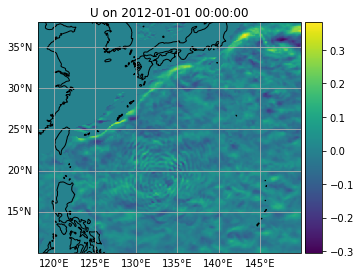

In [3]:
filenames = {'U': directory,
             'V': directory}

# Specify the varaibles and dimensions within those files 
# this information can be found in the description of the HYCOM above.

variables = {'U': 'water_u',
             'V': 'water_v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}

#setting vmin designates HYCOM land cells (<-2000) as 0
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, vmin=-2000) 

fieldset.U.show()


## Mask the land/seabed for 'unbeaching' behaviour

It may be necessary to introduce particle behaviours in response to encountering the seabed/land so these need to be mapped and masked. For this we work on the c-grid coordinates of U and V, not on the grid cell itsellf

In [4]:
#Import the HYCOM Northwest Pacific (nwp) slice as an xarray
nwp = xr.open_dataset(directory)

#Transform all the c-grid values of v or u velocities of 'nan' (seabed) into 1

landmask = np.logical_or(np.ma.masked_invalid(nwp['water_u'][0],0.).mask, # Creates a masked array
                         np.ma.masked_invalid(nwp['water_v'][0],0.).mask)

landmask = landmask.astype('int')
np.ma.masked_invalid(nwp['water_u'][0],0.) #where TRUE/1 = land and FALSE/0 = Ocean

masked_array(
  data=[[--, --, --, ..., -0.0010000000474974513, 0.007000000216066837,
         0.017000000923871994],
        [--, --, --, ..., -0.004000000189989805, 0.003000000026077032,
         0.012000000104308128],
        [--, --, --, ..., -0.007000000216066837, -0.003000000026077032,
         0.005000000353902578],
        ...,
        [--, --, --, ..., 0.017000000923871994, 0.027000000700354576,
         0.03400000184774399],
        [--, --, --, ..., 0.01100000087171793, 0.02200000174343586,
         0.03200000151991844],
        [--, --, --, ..., 0.03100000135600567, 0.03800000250339508,
         0.046000003814697266]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fil

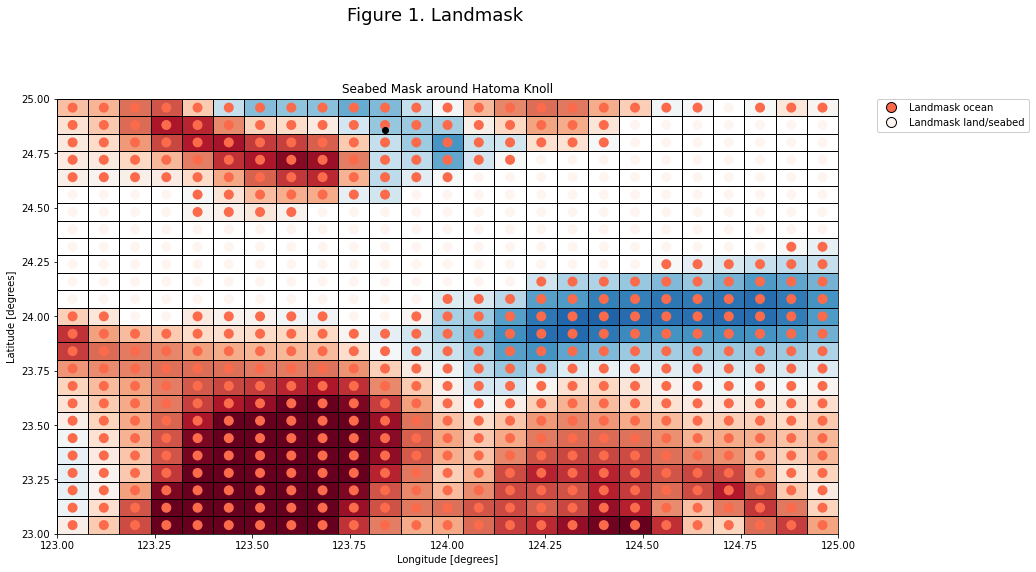

In [5]:
#Merge lat and long data arrays so that each location on the c-grid has a lat and long value on it
lons = fieldset.U.lon
lats = fieldset.U.lat

fieldmesh_x, fieldmesh_y = np.meshgrid(lons, lats)

#Import location of vent data
vent_sites=pd.read_csv('vent_location.csv', index_col = 'vent')

#set figure dimensions
fig = plt.figure(figsize=(14,8))
fig.suptitle('Figure 1. Landmask', fontsize=18, y=1.04)
ax=plt.axes()

#label and limit the axes to focus on small area arround Hatoma Knoll
ax.set_ylabel('Latitude [degrees]')
ax.set_xlabel('Longitude [degrees]')
ax.set_title('Seabed Mask around Hatoma Knoll')
ax.set_xlim(123, 125)
ax.set_ylim(23, 25)

#colour the cells based on their V 
ax.pcolormesh(nwp['lon'], nwp['lat'], nwp['water_v'][0], cmap='RdBu', vmin=-0.1, vmax=0.1, edgecolors='k', linewidth=1)

#plot points at the c-grid coordinats and colour them based on the mask created above
#cmerge is how I transformed lat long into an array that is comparable to glamf and gphif
ax.scatter(fieldmesh_x, fieldmesh_y, c=landmask,  cmap='Reds_r', s=100, edgecolors='k', vmin=-1, linewidth=0.0001)
ax.scatter(vent_sites.at['SPOT, Hatoma Knoll','lon'], vent_sites.at['SPOT, Hatoma Knoll','lat'],c='black')


color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c=color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c=color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax.legend(custom_lines, ['Landmask ocean', 'Landmask land/seabed'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., framealpha=1)



plt.show()



Incorporate Kernal behaviour that has particles avoidng the seabed. To do this the sabed/land neds to be identified and then given a behaviour that moves particles back into the ocean (Boundary Condition) 

In [6]:
def Unbeaching_Field(landmask, fieldmesh_x, fieldmesh_y): # The function requires the input of a landmask and two mesh grids containing the horizontal and vertical information
    
    # Find indices of land and ocean
    oceancells = np.where(landmask == 0)
    landcells = np.where(landmask == 1)
        
    # Create empty arrays
    vectorfield_x = np.zeros(fieldmesh_x.shape)
    vectorfield_y = np.zeros(fieldmesh_y.shape)
        
    # Repeat the loop for all the land cells
    for i1 in range (len(landcells[1])):
        # Find the lon and lat for all of the land cells
        lon_coast = fieldmesh_x[landcells[0][i1], landcells[1][i1]]
        lat_coast = fieldmesh_y[landcells[0][i1], landcells[1][i1]]
            
        # Calculate the distance from each land cell to the ocean cells
        dist_lon = (lon_coast - fieldmesh_x[oceancells[0], oceancells[1]])
        dist_lat = (lat_coast - fieldmesh_y[oceancells[0], oceancells[1]])
        
        # Combine the values to get an array of the distances to ocean cells
        dist_to_ocean = np.sqrt(np.power(dist_lon, 2) + np.power(dist_lat, 2))
        # Calculate the minimum distance from each land cell to the ocean cells
        min_dist = np.min(dist_to_ocean)
        # Find the indices of the minimum distances within the overall distance array
        i_min_dist = np.where(dist_to_ocean == min_dist)
        
        # If there is only one ocean cell that is closest...
        if len(i_min_dist[0]) == 1:
            # Find the lon and lat of the ocean cell
            lon_ocean = fieldmesh_x[oceancells[0][i_min_dist], oceancells[1][i_min_dist]]
            lat_ocean = fieldmesh_y[oceancells[0][i_min_dist], oceancells[1][i_min_dist]]
            
            # Create a vector field 
            vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
            vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
        
        # If there are multiple ocean cells that are closest...
        elif len(i_min_dist[0]) > 1:
            # Take the mean of the lons and lats of all the cells
            lon_ocean = np.mean(fieldmesh_x[oceancells[0][i_min_dist], oceancells[1][i_min_dist]])
            lat_ocean = np.mean(fieldmesh_y[oceancells[0][i_min_dist], oceancells[1][i_min_dist]])
            
            # Create a vector field 
            vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
            vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)    
    
    return vectorfield_x, vectorfield_y

In [7]:
# Apply the function (this may take a while)
landvector_U, landvector_V = Unbeaching_Field(landmask, fieldmesh_x, fieldmesh_y) 

/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15371/3574750108.py:45: RuntimeWarning: invalid value encountered in true_divide
  vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15371/3574750108.py:46: RuntimeWarning: invalid value encountered in true_divide
  vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)


## Map and define settlement locations (Vent sites)

Concept:
If i define settlement behaviour at vent sites, I am assuming that individual larvae are able to respond to cues and actively settle at a hydrothermal vent as long as they are within their competency period. It will be interesting to compare pairwise dispersal probability under this assumption than an assumption that they settle at a defined PLD.

To Do:
- Define a certain number of cells (lit review) around each vent site as settlement cells
- Map and plot to make sure the settlement cells are at vent site locations

In [8]:
landmask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [9]:
fieldmesh_x

array([[118.      , 118.079956, 118.160034, ..., 149.83997 , 149.92004 ,
        150.      ],
       [118.      , 118.079956, 118.160034, ..., 149.83997 , 149.92004 ,
        150.      ],
       [118.      , 118.079956, 118.160034, ..., 149.83997 , 149.92004 ,
        150.      ],
       ...,
       [118.      , 118.079956, 118.160034, ..., 149.83997 , 149.92004 ,
        150.      ],
       [118.      , 118.079956, 118.160034, ..., 149.83997 , 149.92004 ,
        150.      ],
       [118.      , 118.079956, 118.160034, ..., 149.83997 , 149.92004 ,
        150.      ]], dtype=float32)

In [10]:
vent_sites

,lat,lon,depth
vent,,,
Alice Springs Field,18.21030,144.707300,3640
Archaean,12.93900,143.632000,3060
Bayonnaise Knoll caldera,31.96670,139.733300,900
Burke,18.10900,144.432000,3660
Chamorro volcano,20.81000,144.705000,896
Daikoku volcano,21.32400,144.194000,450
Daisan-Kume Knoll,26.30200,126.412500,1370
East Diamante volcano,15.93000,145.670000,457
Forecast,13.40000,143.916600,1470


In [11]:
dist = 1/12+0.00000001 #The size of the grid cell (1/12 a degree)
vent = vent_sites.iloc[0]
#To start make a settlement mask for a single vent site
settlemask = np.logical_and(np.ma.masked_inside(fieldmesh_x, vent.lon - dist, vent.lon + dist).mask, # Creates a masked array
        np.ma.masked_inside(fieldmesh_y, vent.lat - dist, vent.lat + dist).mask)

for i in range(1,len(vent_sites)):
    vent = vent_sites.iloc[i]
    #To start make a settlement mask for a single vent site
    settlemask = np.logical_or(
        settlemask,
        np.logical_and(np.ma.masked_inside(fieldmesh_x, vent.lon - dist, vent.lon + dist).mask, # Creates a masked array
            np.ma.masked_inside(fieldmesh_y, vent.lat - dist, vent.lat + dist).mask)
    )
    
    #Troubleshoot: used np.logical_or instead of logical_and

combined_mask = np.logical_or(settlemask,0)
#settlemask = settlemask.astype('int')
settleval=np.ma.masked_inside(fieldmesh_x, vent_sites.at['SPOT, Hatoma Knoll','lon'] - 0.01, vent_sites.at['SPOT, Hatoma Knoll','lon'] + 0.01) #where TRUE/1 = Hatoma vent site and FALSE/0 = not a vent site
np.where(settlemask) #check where the TRUE value is



(array([ 36,  36,  37,  37,  40,  40,  41,  41,  42,  42,  43,  43,  57,
         57,  58,  58,  68,  68,  69,  69,  74,  74,  75,  75,  86,  86,
         87,  87,  88,  88, 101, 101, 102, 102, 102, 102, 103, 103, 135,
        135, 136, 136, 141, 141, 142, 142, 143, 143, 144, 144, 144, 144,
        145, 145, 146, 146, 163, 163, 164, 164, 185, 185, 185, 185, 185,
        185, 185, 186, 186, 186, 186, 186, 186, 186, 188, 188, 189, 189,
        190, 190, 190, 191, 191, 191, 193, 193, 194, 194, 203, 203, 204,
        204, 206, 206, 207, 207, 208, 208, 209, 209, 215, 215, 216, 216,
        219, 219, 220, 220, 222, 222, 223, 223, 228, 228, 229, 229, 229,
        229, 230, 230, 230, 230, 230, 230, 231, 231, 232, 232, 232, 233,
        233, 233, 268, 268, 269, 269, 273, 273, 274, 274, 274, 274, 275,
        275, 276, 276, 277, 277]),
 array([320, 321, 320, 321, 325, 326, 325, 326, 323, 324, 323, 324, 334,
        335, 334, 335, 331, 332, 331, 332, 345, 346, 345, 346, 335, 336,
        335, 336

Try this again but instead of givving settlement cells a Boolean, give them a number corresponding to their vent id [IN PROGRESS]

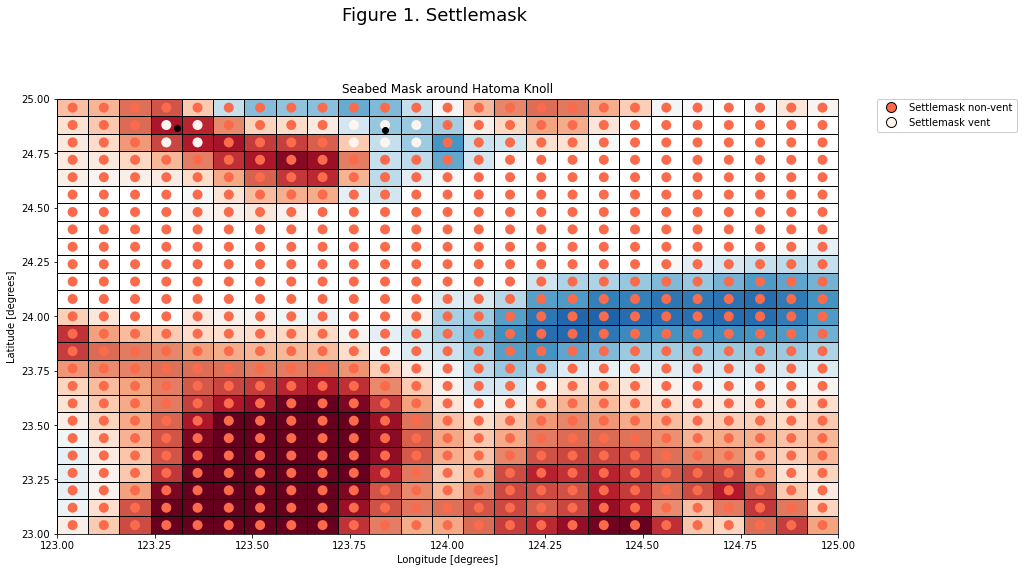

In [12]:
#Merge lat and long data arrays so that each location on the c-grid has a lat and long value on it
lons = fieldset.U.lon
lats = fieldset.U.lat

fieldmesh_x, fieldmesh_y = np.meshgrid(lons, lats)

#Import location of vent data
vent_sites=pd.read_csv('vent_location.csv', index_col = 'vent')

#set figure dimensions
fig = plt.figure(figsize=(14,8))
fig.suptitle('Figure 1. Settlemask', fontsize=18, y=1.04)
ax=plt.axes()

#label and limit the axes to focus on small area arround Hatoma Knoll
ax.set_ylabel('Latitude [degrees]')
ax.set_xlabel('Longitude [degrees]')
ax.set_title('Seabed Mask around Hatoma Knoll')
ax.set_xlim(123, 125)
ax.set_ylim(23, 25)

#colour the cells based on their V 
ax.pcolormesh(nwp['lon'], nwp['lat'], nwp['water_v'][0], cmap='RdBu', vmin=-0.1, vmax=0.1, edgecolors='k', linewidth=1)

#plot points at the c-grid coordinats and colour them based on the mask created above
#cmerge is how I transformed lat long into an array that is comparable to glamf and gphif
ax.scatter(fieldmesh_x, fieldmesh_y, c=settlemask,  cmap='Reds_r', s=100, edgecolors='k', vmin=-1, linewidth=0.0001)
ax.scatter(vent_sites.at['SPOT, Hatoma Knoll','lon'], vent_sites.at['SPOT, Hatoma Knoll','lat'],c='black')
ax.scatter(vent_sites.at['Futagoyama','lon'], vent_sites.at['Futagoyama','lat'],c='black')

color_settle = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c=color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c=color_settle, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax.legend(custom_lines, ['Settlemask non-vent','Settlemask vent'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., framealpha=1)



plt.show()


In [13]:
settlemask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Here I define the 'settlement' which is 1 for a vent site and 0 everywhere else. By replacing this with the 'settleint' i can associate each cell with a vent ID

In [14]:
settlement = settlemask.astype('int') # Convet to integers
np.where(settlement >0)

(array([ 36,  36,  37,  37,  40,  40,  41,  41,  42,  42,  43,  43,  57,
         57,  58,  58,  68,  68,  69,  69,  74,  74,  75,  75,  86,  86,
         87,  87,  88,  88, 101, 101, 102, 102, 102, 102, 103, 103, 135,
        135, 136, 136, 141, 141, 142, 142, 143, 143, 144, 144, 144, 144,
        145, 145, 146, 146, 163, 163, 164, 164, 185, 185, 185, 185, 185,
        185, 185, 186, 186, 186, 186, 186, 186, 186, 188, 188, 189, 189,
        190, 190, 190, 191, 191, 191, 193, 193, 194, 194, 203, 203, 204,
        204, 206, 206, 207, 207, 208, 208, 209, 209, 215, 215, 216, 216,
        219, 219, 220, 220, 222, 222, 223, 223, 228, 228, 229, 229, 229,
        229, 230, 230, 230, 230, 230, 230, 231, 231, 232, 232, 232, 233,
        233, 233, 268, 268, 269, 269, 273, 273, 274, 274, 274, 274, 275,
        275, 276, 276, 277, 277]),
 array([320, 321, 320, 321, 325, 326, 325, 326, 323, 324, 323, 324, 334,
        335, 334, 335, 331, 332, 331, 332, 345, 346, 345, 346, 335, 336,
        335, 336

### Add masks to fieldset

In [15]:
# Convert unbeaching vectors to Field objects
U_land = Field('U_land', landvector_U, lon=lons, lat=lats, fieldtype='U', mesh='spherical')
V_land = Field('V_land', landvector_V, lon=lons, lat=lats, fieldtype='V', mesh='spherical')

# Add to the fieldset
fieldset.add_field(U_land)
fieldset.add_field(V_land)

vectorfield_unbeaching = VectorField('UV_unbeach', U_land, V_land) # Combine and convert to vector field

# Add to fieldset the identification of land and ocean
fieldset.add_field(Field('landmask', landmask, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical')) 

fieldset.add_vector_field(vectorfield_unbeaching) # Add to the fieldset

fieldset.add_field(Field('settlement', settlement, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical')) # Add the settlement cells to the field


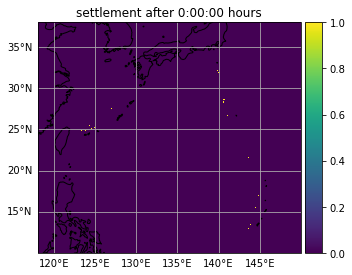

In [16]:
fieldset.settlement.show()

## Define Diffusion

In [17]:
kh_zonal = 100
kh_meridional = 100

size2D = (fieldset.U.grid.ydim, fieldset.U.grid.xdim) # Store the dimensions of the zonal velocity from the FieldSet

fieldset.add_field(Field('Kh_zonal', kh_zonal*np.ones((size2D), dtype=np.float32), lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical'))
fieldset.add_field(Field('Kh_meridional', kh_meridional*np.ones((size2D), dtype=np.float32), lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical'))

fieldset.add_constant('dres', 0.01)

### Define kernal behaviours

In [18]:
#Define a custom kernal that decides whether to unbeach a particle or not based on unbeaching field
def Unbeaching(particle, fieldset, time):
    if particle.on_land == 1:  # If the particle is on land
        (u_land, v_land) = fieldset.UV_unbeach[time, particle.depth, particle.lat, particle.lon]  # the land U and V velocities are used
        particle.lon += u_land * particle.dt # particle lon becomes the u_land field at that timestep
        particle.lat += v_land * particle.dt # particle lat becomes the v_land field at that timestep
        particle.on_land = 0  # the particle is no longer on land

In [19]:
# #Define a custom kernal that records whether a particle is on seabed/land
def Sample_land(particle, fieldset, time):
    particle.on_land = fieldset.landmask[time, particle.depth, particle.lat, particle.lon]
    


In [20]:
#A kernel that  deletes a particle (solution to error messages)
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [21]:
(timedelta(days = 91).total_seconds())

7862400.0

In [22]:
def SampleAge(particle, fieldset, time):
    particle.age += particle.dt 
    
def Particle_death(particle, fieldset, time):
    runtime = 7862400.0 # 91 days (in seconds)
    if particle.age > runtime:
        particle.delete()

Define the settlement by first having the particle record it's location and then defining its 'death' if it reaches a settlement location during its competency period

In [23]:
(timedelta(days = 5).total_seconds())

432000.0

In [24]:
#Try to record the site index when the partical settles

#def Sample_settlement(particle, fieldset, time):
#    particle.settle = fieldset.settlement[time, particle.depth, particle.lat, particle.lon]
    
    
def Sample_settlement(particle, fieldset, time):
    particle.settle = fieldset.settlement[time, particle.depth, particle.lat, particle.lon]
    

def Settle_death(particle, fieldset, time):
    tcomp = 432000 # 5 days (in seconds)
    if particle.age > tcomp and particle.settle > 0:
        particle.delete()

In [25]:
def Distance(particle, fieldset, time):
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2 # latitudinal distance
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi/180) # longitudinal distance
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2)) # calculate Euclidean distance
    particle.prev_lon = particle.lon # Set the values for the next time step   
    particle.prev_lat = particle.lat

## Create Particle set to release in fieldset

### Define custom particles


In [26]:
#Define the data that is recorded for each particle
class CustomParticle(JITParticle):
    #record whether the particle is on land to exhibit 'unbeaching' behaviour
    on_land = Variable('on_land', to_write=False) 
    settle = Variable('settle')
    distance = Variable('distance', dtype=np.float32, initial=0)
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False, initial=attrgetter('lon'))
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False, initial=attrgetter('lat'))
    age = Variable('age', dtype=np.float32, initial=0, to_write=False)



### Create Particle set

PROBLEM: When I specify a list of random times between dates for particles to release, the number of particles i can use is limited. 

SOLUTION: by changing the unit of measurement of the time from seconds to days

In [27]:

n = 1000 # Number of particle

#Defining a random start time is restricting the number of particles I can release for some unknown reason
def random_dates(start, end, n=n):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')


In [28]:
#Import location of vent data
vent_sites=pd.read_csv('vent_location.csv', index_col = 'vent')



#Use location of Hatoma Knoll as the point of dispersal

lat = list(np.repeat(vent_sites.at['SPOT, Hatoma Knoll','lat'],n))
lon = list(np.repeat(vent_sites.at['SPOT, Hatoma Knoll','lon'],n))


#Create a list of random dates and time using the above function
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2012-02-01')
random_start=random_dates(start, end)

#Round up to days
random_start = random_start.round('D')

random_start = np.expand_dims(random_start,axis=1)




In [29]:

pset = ParticleSet(fieldset=fieldset, # The fieldset created at the start
                   pclass=CustomParticle, # The CustomParticle CustomParticle defined above
                   lon=lon, # longitude data
                   lat=lat, # latitude data
                   time=random_start) # Don't need to randomize time because diffusion will spread the particles



### Implement kernel behaviours defined above

In [30]:
# Cutom kernels need to be cast into a kernel object using pset.Kernel before they can function 
kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(Particle_death) + pset.Kernel(Sample_land) + pset.Kernel(Unbeaching) + pset.Kernel(DiffusionUniformKh) + pset.Kernel(SampleAge) + pset.Kernel(Distance) + pset.Kernel(Sample_land) + pset.Kernel(Sample_settlement) + pset.Kernel(Settle_death)



## Execute PARCELS!

In [31]:
# input the time manually (as hours since 2000-01-01 00:00:00 )
output_file = pset.ParticleFile(name="Oki_advdif_particles.nc", outputdt= timedelta(days=1)) # the file name and the time step of the outputs [I had issues with the 'timedelta' so i just changed it to a positive double (1)]
pset.execute(kernels,                 # the kernel (which defines how particles move)
             runtime= timedelta(days=200),    # the total length of the run
             dt= timedelta(minutes=1),          # the timestep of the kernel
             recovery ={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                        ErrorCode.ErrorInterpolation: DeleteParticle},# How to handle error messages
             output_file=output_file)

INFO: Compiled ArrayCustomParticleAdvectionRK4Particle_deathSample_landUnbeachingDiffusionUniformKhSampleAgeDistanceSample_landSample_settlementSettle_death ==> /var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/parcels-502/lib4e9414f2ad77627dfd34fb2a65492099_0.so
INFO: Temporary output files are stored in out-VIIOXQWB.
INFO: You can use "parcels_convert_npydir_to_netcdf out-VIIOXQWB" to convert these to a NetCDF file during the run.
 52% (8985600.0 of 17280000.0) |####     | Elapsed Time: 0:00:07 ETA:   0:00:05WARNING: ParticleSet is empty on writing as array at time 9.1584e+06
 53% (9158400.0 of 17280000.0) |####     | Elapsed Time: 0:00:07 ETA:   0:00:05WARNING: ParticleSet is empty on writing as array at time 9.2448e+06
 54% (9331200.0 of 17280000.0) |####     | Elapsed Time: 0:00:07 ETA:   0:00:04WARNING: ParticleSet is empty on writing as array at time 9.4176e+06
 55% (9590400.0 of 17280000.0) |####     | Elapsed Time: 0:00:07 ETA:   0:00:04WARNING: ParticleSet is empty on writing 

 91% (15811200.0 of 17280000.0) |####### | Elapsed Time: 0:00:10 ETA:   0:00:00WARNING: ParticleSet is empty on writing as array at time 1.58976e+07
 92% (15984000.0 of 17280000.0) |####### | Elapsed Time: 0:00:10 ETA:   0:00:00WARNING: ParticleSet is empty on writing as array at time 1.60704e+07
 94% (16243200.0 of 17280000.0) |####### | Elapsed Time: 0:00:10 ETA:   0:00:00WARNING: ParticleSet is empty on writing as array at time 1.63296e+07
 95% (16416000.0 of 17280000.0) |####### | Elapsed Time: 0:00:10 ETA:   0:00:00WARNING: ParticleSet is empty on writing as array at time 1.65024e+07
 96% (16675200.0 of 17280000.0) |####### | Elapsed Time: 0:00:10 ETA:   0:00:00WARNING: ParticleSet is empty on writing as array at time 1.67616e+07
 97% (16848000.0 of 17280000.0) |####### | Elapsed Time: 0:00:10 ETA:   0:00:00WARNING: ParticleSet is empty on writing as array at time 1.69344e+07
 99% (17107200.0 of 17280000.0) |####### | Elapsed Time: 0:00:10 ETA:   0:00:00WARNING: ParticleSet is emp

/Users/rentalforgsst37527/opt/anaconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


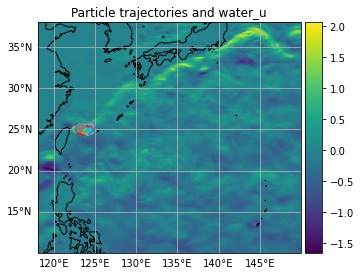

In [32]:
output_file.export()
plotTrajectoriesFile('Oki_advdif_particles.nc',
                     tracerfile='HYCOM/nwp_surf_2012-01-01.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='water_u');

## Analyse Trajectory Output 


The output I require is the number of particles that reach each vent site. To do this I need to identify the terminal location of each particle (probability density) and then extract this density for each grid cell that contains a vent site


In [33]:
#Import the trajectory output as an Xarray

import xarray as xr

x_output = xr.open_dataset('Oki_advdif_particles.nc')
x_output

<xarray.Dataset>
Dimensions:     (traj: 1000, obs: 93)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    settle      (traj, obs) float32 ...
    distance    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

In [34]:
output = x_output.to_dataframe()
output

trajectory       time        lat         lon    z    settle  \
traj obs                                                                
0    0           0.0 2012-01-03  24.855000  123.841003  0.0  0.000000   
     1           0.0 2012-01-04  24.907024  123.763229  0.0  0.662184   
     2           0.0 2012-01-05  24.925467  123.723473  0.0  0.234405   
     3           0.0 2012-01-06  24.938679  123.597649  0.0  0.000000   
     4           0.0 2012-01-07  24.902245  123.559799  0.0  0.000000   
...              ...        ...        ...         ...  ...       ...   
999  88          NaN        NaT        NaN         NaN  NaN       NaN   
     89          NaN        NaT        NaN         NaN  NaN       NaN   
     90          NaN        NaT        NaN         NaN  NaN       NaN   
     91          NaN        NaT        NaN         NaN  NaN       NaN   
     92          NaN        NaT        NaN         NaN  NaN       NaN   

            distance  
traj obs              
0    0      0.000000  
     1    196.795380  
     2    394.288361  
     3    592.991211  
     4    788.736694  
...              ...  
999  88          NaN  
     89          NaN  
     90          NaN  
     91          NaN  
     92          NaN  

[93000 rows x 7 columns]

In [35]:
output['settle']

traj  obs
0     0      0.000000
      1      0.662184
      2      0.234405
      3      0.000000
      4      0.000000
               ...   
999   88          NaN
      89          NaN
      90          NaN
      91          NaN
      92          NaN
Name: settle, Length: 93000, dtype: float32

In [36]:
np.where(output['distance']>0)

(array([    1,     2,     3, ..., 92912, 92913, 92914]),)

In [37]:
output.loc[output['settle'] >0].index

MultiIndex([(  0,  1),
            (  0,  2),
            (  0,  7),
            (  1,  1),
            (  1, 10),
            (  2,  1),
            (  2,  2),
            (  2,  3),
            (  2,  4),
            (  2,  5),
            ...
            (996,  6),
            (997,  1),
            (997, 68),
            (998,  1),
            (998,  2),
            (998,  3),
            (998,  4),
            (998,  6),
            (999,  1),
            (999,  7)],
           names=['traj', 'obs'], length=3746)

In [38]:
index = output['settle'].index[output['settle'].apply(np.isnan)]
index


MultiIndex([(  0,  8),
            (  0,  9),
            (  0, 10),
            (  0, 11),
            (  0, 12),
            (  0, 13),
            (  0, 14),
            (  0, 15),
            (  0, 16),
            (  0, 17),
            ...
            (999, 83),
            (999, 84),
            (999, 85),
            (999, 86),
            (999, 87),
            (999, 88),
            (999, 89),
            (999, 90),
            (999, 91),
            (999, 92)],
           names=['traj', 'obs'], length=80801)

In [39]:
np.where(output['settle']>0)

(array([    1,     2,     7, ..., 92820, 92908, 92914]),)

Extract the lat long of each partical before it is terminated to determine where it settled/died [To DO]

In [48]:
vent_sites

,lat,lon,depth
vent,,,
Alice Springs Field,18.21030,144.707300,3640
Archaean,12.93900,143.632000,3060
Bayonnaise Knoll caldera,31.96670,139.733300,900
Burke,18.10900,144.432000,3660
Chamorro volcano,20.81000,144.705000,896
Daikoku volcano,21.32400,144.194000,450
Daisan-Kume Knoll,26.30200,126.412500,1370
East Diamante volcano,15.93000,145.670000,457
Forecast,13.40000,143.916600,1470


/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15371/3110453268.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_output['lon'][:,90], x_output['lat'][:,90],
/var/folders/gl/8vzxpv2903d5t3y25sg8b66m0000gp/T/ipykernel_15371/3110453268.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^" (-> color='r'). The keyword argument will take precedence.
  ax.plot(vent_sites.at['SPOT, Hatoma Knoll','lon'], vent_sites.at['SPOT, Hatoma Knoll','lat'],


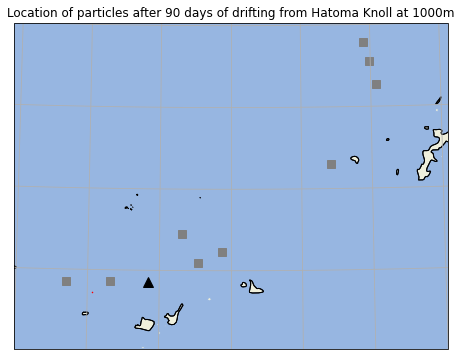

In [52]:
import cartopy.feature as cfeature


# Create a spatial map of your selected location with cartopy
# Full extnet 118, 150, 10, 38 
#25.671710817443696, 125.73526892535367 24.228078631571, 123.22629785335853

#extent = [118, 150, 10, 38 ]

extent = [122, 128, 24, 28]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),
                     subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(x_output['lon'][:,90], x_output['lat'][:,90], 
        'r*', 
        transform=ccrs.PlateCarree(),
       color="red", markersize=1)

ax.plot(vent_sites.at['SPOT, Hatoma Knoll','lon'], vent_sites.at['SPOT, Hatoma Knoll','lat'], 
        'r^', 
        transform=ccrs.PlateCarree(),
       color="black", markersize=10)

# Find a more efficient way to plt vent sites
ax.plot(vent_sites.at['Daisan-Kume Knoll','lon'], vent_sites.at['Daisan-Kume Knoll','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Futagoyama','lon'], vent_sites.at['Futagoyama','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Hafa Adai','lon'], vent_sites.at['Hafa Adai','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Irabu Knoll','lon'], vent_sites.at['Irabu Knoll','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Izena Cauldron','lon'], vent_sites.at['Izena Cauldron','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Minami-Ensei Knoll','lon'], vent_sites.at['Minami-Ensei Knoll','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['North Knoll, Iheya Ridge','lon'], vent_sites.at['North Knoll, Iheya Ridge','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Sakai','lon'], vent_sites.at['Sakai','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)


ax.plot(vent_sites.at['SPOT, Yonaguni Knoll IV','lon'], vent_sites.at['SPOT, Yonaguni Knoll IV','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Tarama Hill','lon'], vent_sites.at['Tarama Hill','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)

ax.plot(vent_sites.at['Tarama Knoll','lon'], vent_sites.at['Tarama Knoll','lat'], 
        's', 
        transform=ccrs.PlateCarree(),
       color="grey", markersize=8)


ax.set_extent(extent)
ax.set(title="Location of particles after 90 days of drifting from Hatoma Knoll at 1000m")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

ax.gridlines()
plt.show()